$ \begin{cases} 
      X := N_X \\
      Y := X^2 + N_Y \\
   \end{cases}
$ 

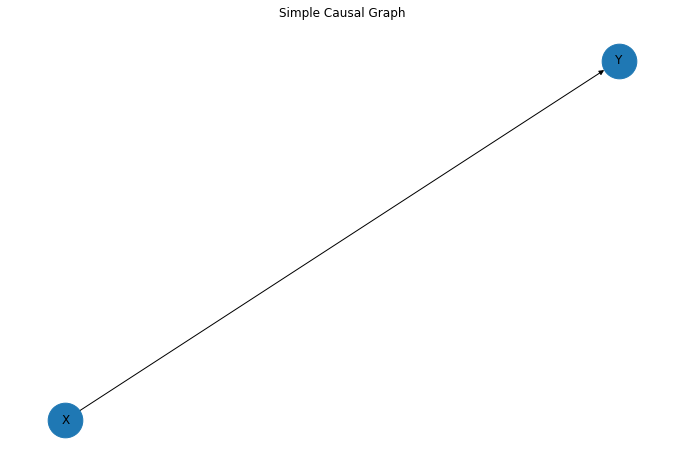

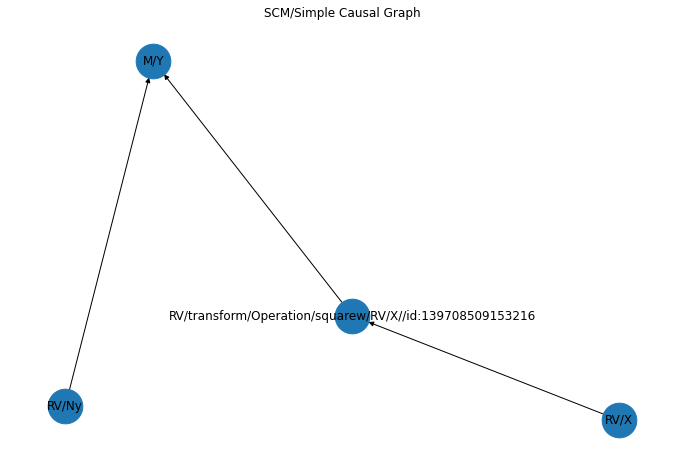

In [1]:
from pycausal import *
from scipy import stats
model = SCM("Simple Causal Graph")
X = Variable("X", stats.norm(loc=0,scale=1))

Ny = HiddenVariable("Ny", stats.norm(loc=0, scale=1)) 

Y = add( square(X), Ny).mark("Y")
model.draw()
model.draw_complete()

In [2]:
data = model.sample(200)

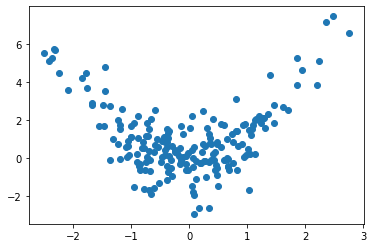

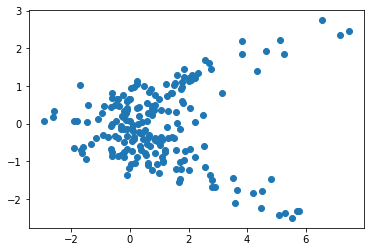

In [3]:
import matplotlib.pyplot as plt

plt.scatter(data["X"],data["Y"])
plt.show()

plt.scatter(data["Y"],data["X"])
plt.show()

/home/graf/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/home/graf/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/home/graf/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


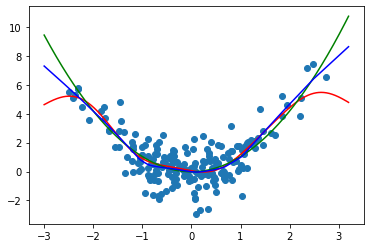

In [39]:
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor

rvfmodel = SVR(kernel="rbf", degree=2)
mlp = MLPRegressor(hidden_layer_sizes=(100, 100,100), activation="relu",max_iter=2000)
rmodel = SVR(kernel="poly", degree=2)

rvfmodel.fit( data["X"], data["Y"])
rmodel.fit( data["X"], data["Y"])
mlp.fit( data["X"], data["Y"])

x = np.linspace(-3,3.2,1000).reshape(-1,1)

plt.scatter(data["X"],data["Y"])
plt.plot(x ,rvfmodel.predict(x),color="red") 
plt.plot(x ,rmodel.predict(x),color="green") 
plt.plot(x ,mlp.predict(x),color="blue") 

plt.show()

In [40]:
print("poly:")
print(rmodel.score(data["X"],data["Y"]))

print("rbf:")
print(rvfmodel.score(data["X"],data["Y"]))

print("mlp:")
print(mlp.score(data["X"],data["Y"]))

poly:
0.6667714995376175
rbf:
0.6712699416318784
mlp:
0.6860184004972745


In [36]:
resids = [ m.predict(data["X"]) - data["Y"].ravel() for m in [mlp, rvfmodel, rmodel] ]
    
tests = [ hsic_gam(r.reshape(-1,1),data["X"]) for r in resids ]
result = [ t[0] < t[1] for t in tests]
print(result)

[True, True, True]


/home/graf/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/home/graf/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/home/graf/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


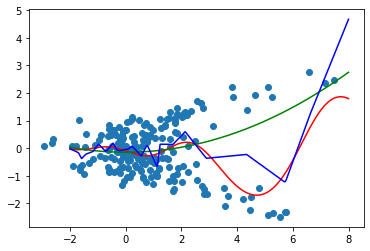

In [37]:
from sklearn.svm import SVR

rvfmodel = SVR(kernel="rbf", degree=2)

rmodel = SVR(kernel="poly", degree=2)

mlp = MLPRegressor(hidden_layer_sizes=(100, 100,100), activation="relu",max_iter=2000)


rvfmodel.fit( data["Y"].reshape(-1,1), data["X"])
rmodel.fit( data["Y"].reshape(-1,1), data["X"])
mlp.fit( data["Y"].reshape(-1,1), data["X"])

x = np.linspace(-2,8,1000)

plt.scatter(data["Y"],data["X"])
plt.plot(x ,rvfmodel.predict(x.reshape(-1,1)),color="red")
plt.plot(x ,rmodel.predict(x.reshape(-1,1)),color="green")
plt.plot(x ,mlp.predict(x.reshape(-1,1)),color="blue")

plt.show()

In [38]:
print("poly:")
print(rmodel.score(data["Y"].reshape(-1,1),data["X"]))

print("rbf:")
print(rvfmodel.score(data["Y"].reshape(-1,1),data["X"]))

poly:
-0.11462974737152631
rbf:
0.057347032148863386


In [16]:
"""
python implementation of Hilbert Schmidt Independence Criterion
hsic_gam implements the HSIC test using a Gamma approximation
Python 2.7.12
Gretton, A., Fukumizu, K., Teo, C. H., Song, L., Scholkopf, B., 
& Smola, A. J. (2007). A kernel statistical test of independence. 
In Advances in neural information processing systems (pp. 585-592).
Shoubo (shoubo.sub AT gmail.com)
09/11/2016
Inputs:
X n by dim_x matrix
Y n by dim_y matrix
alph level of test
Outputs:
testStat  test statistics
thresh  test threshold for level alpha test
"""

from __future__ import division
import numpy as np
from scipy.stats import gamma

def rbf_dot(pattern1, pattern2, deg):
    size1 = pattern1.shape
    size2 = pattern2.shape

    G = np.sum(pattern1*pattern1, 1).reshape(size1[0],1)
    H = np.sum(pattern2*pattern2, 1).reshape(size2[0],1)

    Q = np.tile(G, (1, size2[0]))
    R = np.tile(H.T, (size1[0], 1))

    H = Q + R - 2* np.dot(pattern1, pattern2.T)

    H = np.exp(-H/2/(deg**2))

    return H


def hsic_gam(X, Y, alph = 0.5):
    """
    X, Y are numpy vectors with row - sample, col - dim
    alph is the significance level
    auto choose median to be the kernel width
    """
    n = X.shape[0]

    # ----- width of X -----
    Xmed = X

    G = np.sum(Xmed*Xmed, 1).reshape(n,1)
    Q = np.tile(G, (1, n) )
    R = np.tile(G.T, (n, 1) )

    dists = Q + R - 2* np.dot(Xmed, Xmed.T)
    dists = dists - np.tril(dists)
    dists = dists.reshape(n**2, 1)

    width_x = np.sqrt( 0.5 * np.median(dists[dists>0]) )
    # ----- -----

    # ----- width of X -----
    Ymed = Y

    G = np.sum(Ymed*Ymed, 1).reshape(n,1)
    Q = np.tile(G, (1, n) )
    R = np.tile(G.T, (n, 1) )

    dists = Q + R - 2* np.dot(Ymed, Ymed.T)
    dists = dists - np.tril(dists)
    dists = dists.reshape(n**2, 1)

    width_y = np.sqrt( 0.5 * np.median(dists[dists>0]) )
    # ----- -----

    bone = np.ones((n, 1), dtype = float)
    H = np.identity(n) - np.ones((n,n), dtype = float) / n

    K = rbf_dot(X, X, width_x)
    L = rbf_dot(Y, Y, width_y)

    Kc = np.dot(np.dot(H, K), H)
    Lc = np.dot(np.dot(H, L), H)

    testStat = np.sum(Kc.T * Lc) / n

    varHSIC = (Kc * Lc / 6)**2

    varHSIC = ( np.sum(varHSIC) - np.trace(varHSIC) ) / n / (n-1)

    varHSIC = varHSIC * 72 * (n-4) * (n-5) / n / (n-1) / (n-2) / (n-3)

    K = K - np.diag(np.diag(K))
    L = L - np.diag(np.diag(L))

    muX = np.dot(np.dot(bone.T, K), bone) / n / (n-1)
    muY = np.dot(np.dot(bone.T, L), bone) / n / (n-1)

    mHSIC = (1 + muX * muY - muX - muY) / n

    al = mHSIC**2 / varHSIC
    bet = varHSIC*n / mHSIC

    thresh = gamma.ppf(1-alph, al, scale=bet)[0][0]

    return (testStat, thresh)